# Proje:Tüketici Şikayet Sınıflandırması (Consumer Complaint Classification)

Tüketici Şikayet Sınıflandırması, tüketici tarafından bildirilen şikayetin niteliğini sınıflandırmak anlamına gelir. Tüketici bakım departmanları için faydalıdır çünkü her gün binlerce şikayet alırlar, bu nedenle bunları sınıflandırmak, tüketicinin kaybını azaltmak için önce çözülmesi gereken şikayetleri belirlemeye yardımcı olur.

Veriseti:  https://statso.io/consumer-complaint-identification-case-study/

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import nltk
import re
from nltk.corpus import stopwords
import string

In [3]:
df = pd.read_csv('data/data.csv')
df.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative
0,0,2022-11-11,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN
1,1,2022-11-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN
2,2,2022-11-16,Mortgage,VA mortgage,Trouble during payment process,NaN,NaN
3,3,2022-11-15,Checking or savings account,Checking account,Managing an account,Fee problem,"Hi, I have been banking with Wells Fargo for o..."
4,4,2022-11-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN


In [4]:
df = df.drop("Unnamed: 0",axis=1)

In [5]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235294
Issue                                 0
Sub-issue                        683355
Consumer complaint narrative    1987977
dtype: int64

In [6]:
df=df.dropna()

In [7]:
df['Product'].unique()

array(['Checking or savings account', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card', 'Student loan',
       'Vehicle loan or lease',
       'Payday loan, title loan, or personal loan'], dtype=object)

## Model Eğitimi:

Metin verilerini temizlemek ve işlemek için nltk kütüphanesini kullanacağız.

Fonksiyon şu adımları gerçekleştirecek:

* Metni küçük harfe çevirir.
* Köşeli parantez içindeki içerikleri kaldırır.
* URL'leri temizler.
* HTML etiketlerini kaldırır.
* Noktalama işaretlerini siler.
* Yeni satır karakterlerini kaldırır.
* Sayı içeren kelimeleri çıkarır.
* Durak kelimeleri (stopwords) kaldırır.
* Kalan kelimelere kök bulma (stemming) işlemi uygular.

In [8]:
from tqdm import tqdm

nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

tqdm.pandas()
df["Consumer complaint narrative"] = df["Consumer complaint narrative"].progress_apply(clean)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/talipakhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 887808/887808 [09:33<00:00, 1548.10it/s]


In [9]:
df = df[["Consumer complaint narrative", "Product"]]
x = np.array(df["Consumer complaint narrative"])
y = np.array(df["Product"])

cv = CountVectorizer()
X = cv.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [10]:
sgdmodel = SGDClassifier()
sgdmodel.fit(X_train,y_train)

SGDClassifier()

Çapraz doğrulama yapılıyor...


Çapraz Doğrulama: 100%|██████████| 5/5 [12:14<00:00, 146.99s/it]


Çapraz doğrulama skorları: [0.8675448575708766, 0.8640700149806828, 0.8629267523456595, 0.8676068077629222, 0.8665029679773826]
Ortalama çapraz doğrulama skoru: 0.8657
Test seti üzerinde tahmin yapılıyor...

Sınıflandırma Raporu:
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.88      0.81      0.84     17766
                                                 Credit card or prepaid card       0.83      0.73      0.78     26332
Credit reporting, credit repair services, or other personal consumer reports       0.88      0.94      0.91    167824
                                                             Debt collection       0.82      0.78      0.80     63496
                                   Payday loan, title loan, or personal loan       0.00      0.00      0.00       328
                                                             

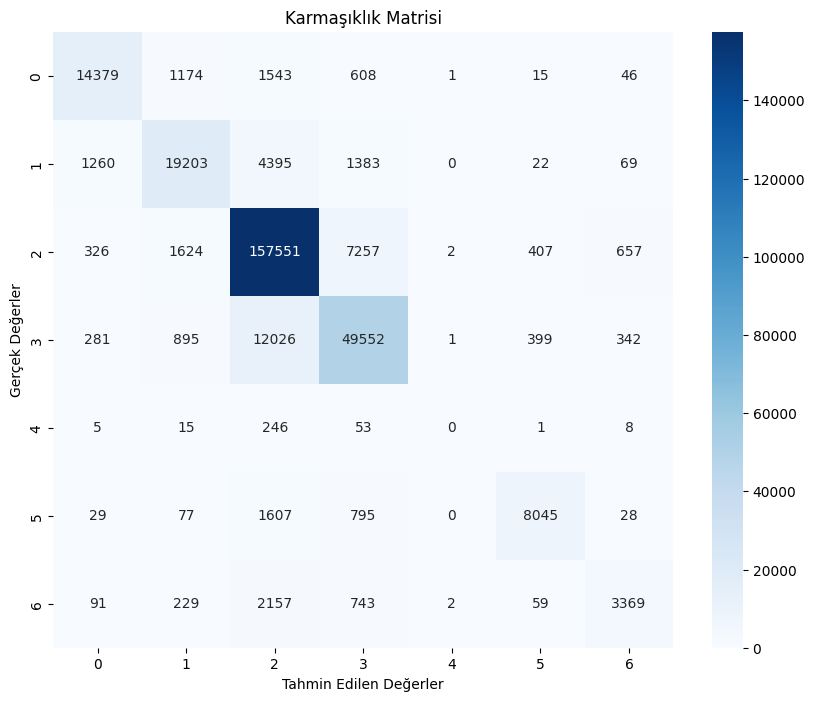

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Çapraz doğrulama
print("Çapraz doğrulama yapılıyor...")
cv_scores = []
for _ in tqdm(range(5), desc="Çapraz Doğrulama"):
    cv_scores.append(cross_val_score(sgdmodel, X, y, cv=5)[0])

print(f"Çapraz doğrulama skorları: {cv_scores}")
print(f"Ortalama çapraz doğrulama skoru: {np.mean(cv_scores):.4f}")

# 2. Test seti üzerinde tahmin yapma
print("Test seti üzerinde tahmin yapılıyor...")
y_pred = sgdmodel.predict(X_test)

# 3. Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# 4. Karmaşıklık matrisi
print("Karmaşıklık matrisi oluşturuluyor...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


In [12]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatization eklendi
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

tqdm.pandas()
df["Consumer complaint narrative"] = df["Consumer complaint narrative"].progress_apply(clean)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/talipakhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/talipakhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 887808/887808 [10:59<00:00, 1346.29it/s]


In [13]:
from gensim.models import Word2Vec
import numpy as np
from tqdm.notebook import tqdm

# Metinleri kelimelere ayırma
print("Metinler kelimelere ayrılıyor...")
texts = df["Consumer complaint narrative"].progress_apply(lambda x: x.split())

# Word2Vec modelini eğitme
print("Word2Vec modeli eğitiliyor...")
w2v_model = Word2Vec(sentences=tqdm(texts, desc="Word2Vec Eğitimi"), vector_size=100, window=5, min_count=1, workers=4)

# Metin vektörlerini oluşturma fonksiyonu
def get_document_vector(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Metin vektörlerini oluşturma
print("Metin vektörleri oluşturuluyor...")
X = np.array(df["Consumer complaint narrative"].progress_apply(get_document_vector).tolist())
y = df["Product"].values

# Veri setini bölme
print("Veri seti bölünüyor...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Metinler kelimelere ayrılıyor...


100%|██████████| 887808/887808 [00:16<00:00, 54629.19it/s] 

Word2Vec modeli eğitiliyor...


Word2Vec Eğitimi:   0%|          | 0/887808 [00:00<?, ?it/s]

Metin vektörleri oluşturuluyor...


100%|██████████| 887808/887808 [01:14<00:00, 11943.62it/s]


Veri seti bölünüyor...


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# t-SNE uygulama
print("t-SNE uygulanıyor...")
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tqdm(X, desc="t-SNE İlerlemesi"))

# Görselleştirme
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.astype('int').values, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Text Vectors')
plt.show()



Metinler birleştiriliyor...


Metin Birleştirme:   0%|          | 0/887808 [00:00<?, ?it/s]

WordCloud oluşturuluyor...


WordCloud Oluşturma:   0%|          | 0/100 [00:00<?, ?it/s]

WordCloud oluşturma süresi: 305.42 saniye


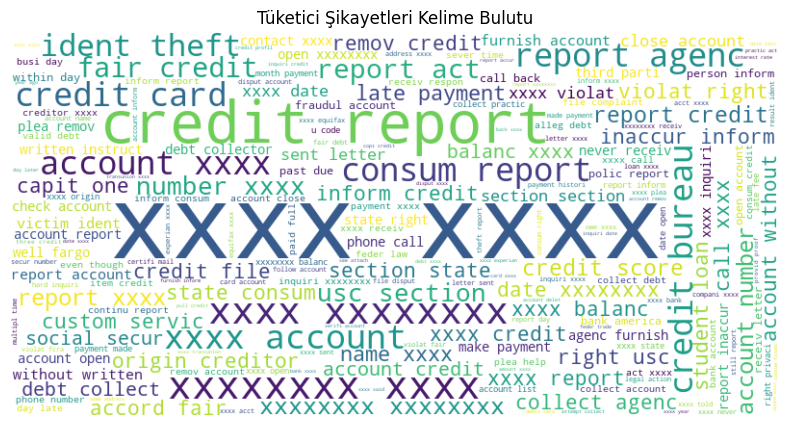

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Tüm metinleri birleştirme
print("Metinler birleştiriliyor...")
text = ' '.join(tqdm(df['Consumer complaint narrative'], desc="Metin Birleştirme"))

# WordCloud nesnesini oluşturma
print("WordCloud oluşturuluyor...")
with tqdm(total=100, desc="WordCloud Oluşturma") as pbar:
    start_time = time.time()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    pbar.update(100)
    end_time = time.time()

print(f"WordCloud oluşturma süresi: {end_time - start_time:.2f} saniye")

# Görselleştirme
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tüketici Şikayetleri Kelime Bulutu')
plt.show()


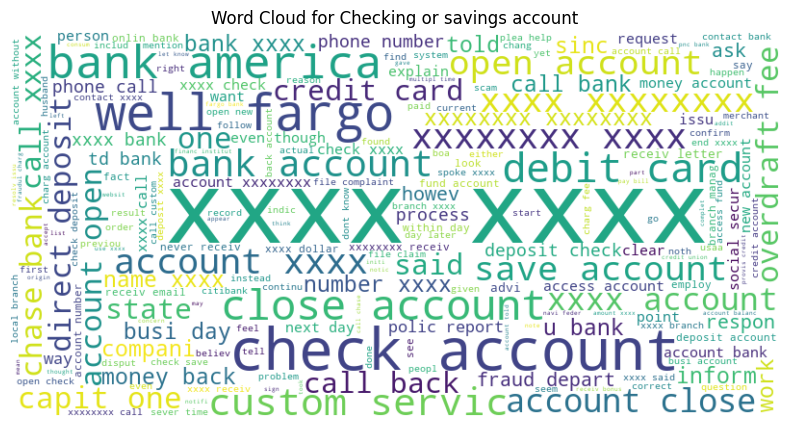

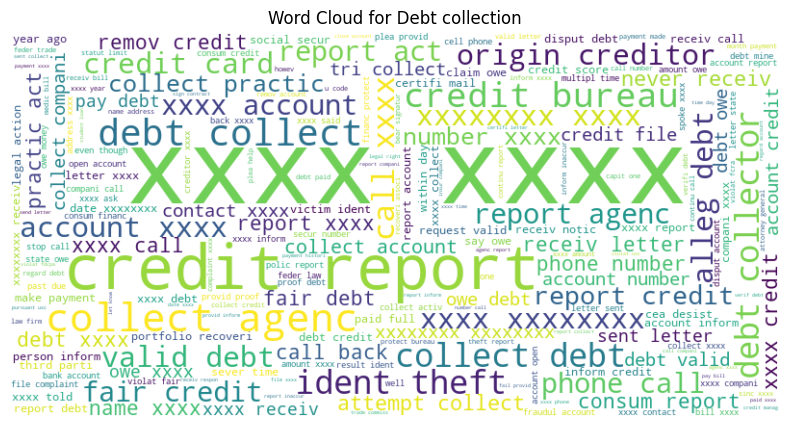

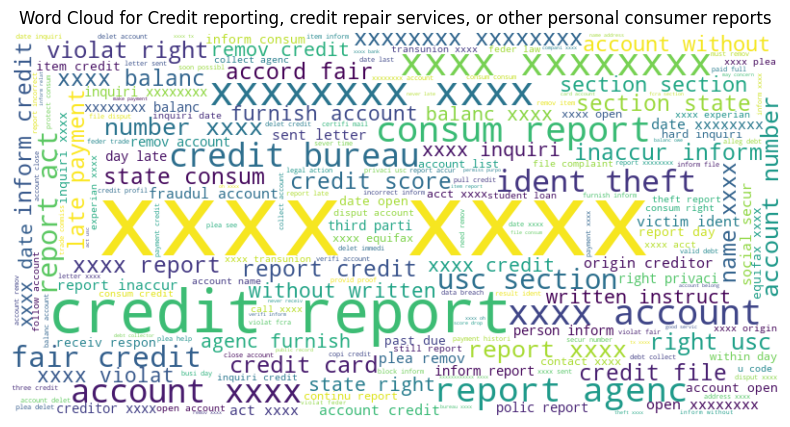

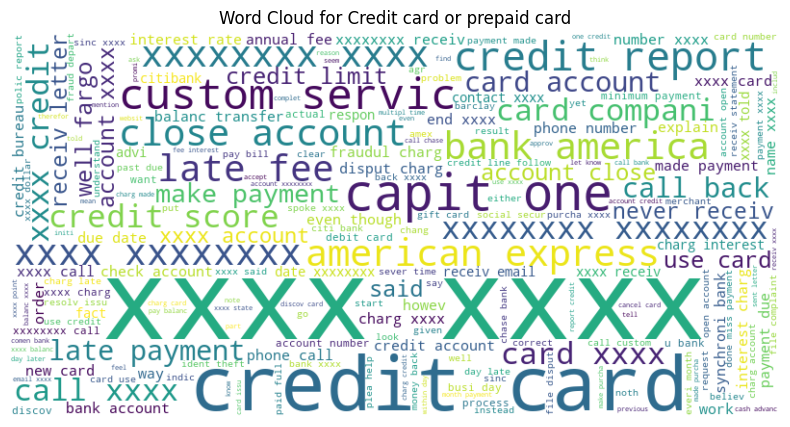

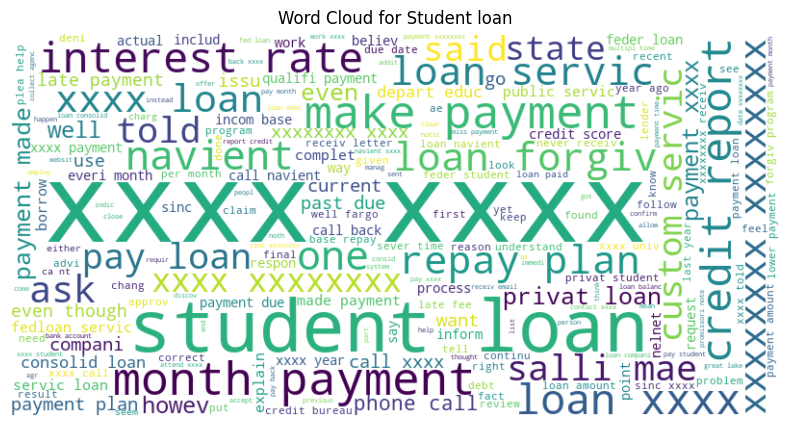

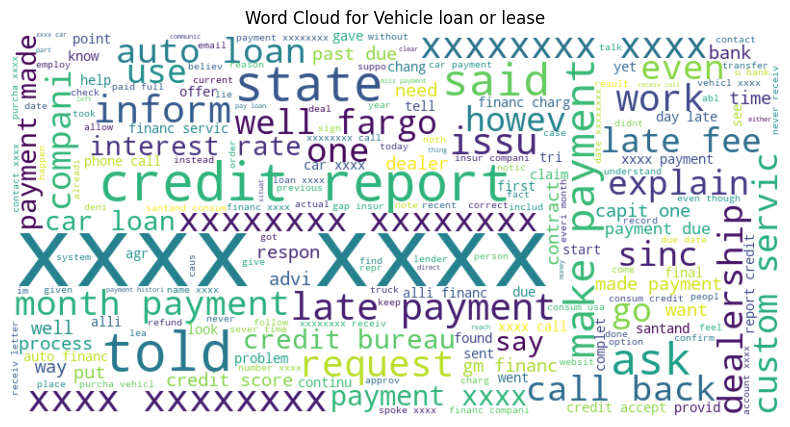

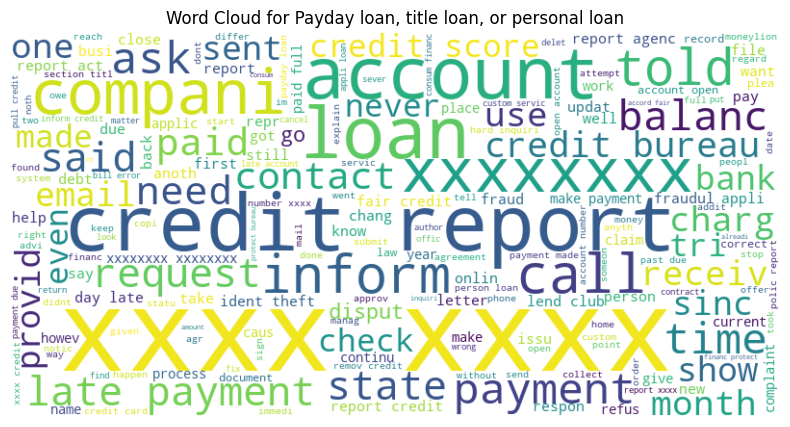

In [26]:
# Her ürün kategorisi için kelime bulutu oluşturma
for product in df['Product'].unique():
    # Ürüne ait şikayetleri filtreleme
    product_complaints = df[df['Product'] == product]['Consumer complaint narrative']
    
    # Metinleri birleştirme
    text = ' '.join(product_complaints)
    
    # WordCloud nesnesini oluşturma
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Görselleştirme
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {product}')
    plt.show()


tahmin:

In [14]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = sgdmodel.predict(data)
print(output)

['Credit reporting, credit repair services, or other personal consumer reports']


In [15]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = sgdmodel.predict(data)
print(output)

['Credit reporting, credit repair services, or other personal consumer reports']


# Sonuç:

Tüketici Şikayet Sınıflandırması, tüketici hizmetleri departmanları için faydalıdır çünkü her gün binlerce şikayet alırlar, bu nedenle bunları sınıflandırmak, tüketicinin kaybını azaltmak için öncelikle çözülmesi gereken şikayetleri belirlemeye yardımcı olur.